In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io
from scipy.interpolate import griddata
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')


In [3]:
np.random.seed(1234)
tf.set_random_seed(1234)

In [5]:
class NN:
    def __init__(self, x, u, layers, activation, lr):
        self.x = x
        self.u = u
        self.lr = lr
        self.activation = activation
        self.loss_log = []

        self.weights, self.biases = self.initilize_NN(layers)
        self.sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
        self.x_tf = tf.placeholder(tf.float32, shape=[None, self.x.shape[1]])
        self.u_tf = tf.placeholder(tf.float32, shape=[None, self.u.shape[1]])

        self.u_pred = self.net_u(self.x_tf)

        self.loss = tf.reduce_mean(tf.square(self.u_tf - self.u_pred))

        steps_per_decay = 1000
        decay_factor = 0.9
        self.global_step = tf.Variable(0, trainable=False)
        self.lr = tf.train.exponential_decay(learning_rate = lr,
                                           global_step = self.global_step,
                                           decay_steps = steps_per_decay,
                                           decay_rate = decay_factor,
                                           staircase = True
                                           )
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.lr).minimize(self.loss,
                                            global_step=self.global_step)
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def initilize_NN(self, layers):
        weights = []
        biases  = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)

    def neural_net(self, X, weights, biases, activation):
        num_layers = len(weights) + 1
        H = X
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            H = activation(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

    def net_u(self, x):
        u = self.neural_net(x, self.weights, self.biases, self.activation)
        return u

    def callback(self, loss, res, deriv):
        print('Loss:%f,res:%f'%(loss, res))

    def train(self, max_iter=40000):
        loss_value = np.inf
        for iter in range(max_iter):
            self.sess.run(self.global_step)
            tf_dict = {
                self.x_tf:self.x,
                self.u_tf:self.u
            }
            _, loss_value = self.sess.run([self.optimizer,
                self.loss], tf_dict)
            self.sess.run(self.lr)
            if iter % 2000 == 0:
                print("第%d次 %f"%(iter, loss_value))
        print("第%d次的损失为%f"%(max_iter, loss_value))
        print("最终lr为%f"%(self.sess.run(self.lr)))

    def predict(self, X_star):
        u_star = self.sess.run(self.u_pred, {self.x_tf: X_star})
        return u_star

In [6]:
layers = [1, 20, 20, 20, 20, 1]
activation = tf.tanh
lr = 1e-3
iterations = 10000

In [7]:
def train_model(train_num):
    x = np.linspace(0, 1, train_num)[:, None]
    u = -(1.4-3*x)*np.sin(18*x)
    start_time = time.time()
    NN_tanh = NN(x, u, layers, activation, lr)
    print("Start training! train_num:%d"%(train_num))
    NN_tanh.train(iterations)
    elapsed = time.time() - start_time
    print('Training time: %.4f' % (elapsed))
    return NN_tanh

In [8]:
def compute_error(model, test_num):
    x_test   = np.linspace(0, 1, test_num)[:, None]
    u_test   = -(1.4-3*x_test)*np.sin(18*x_test)
    u_pred   = model.predict(x_test)
    L2_norm  = np.linalg.norm(u_test-u_pred,2)/np.linalg.norm(u_test,2)
    return L2_norm

In [5]:
train_nums = np.arange(5, 31, 1)

In [ ]:
test_num   = 1000
errors     = []
for train_num in train_nums:
    model = train_model(train_num)
    error = compute_error(model, test_num)
    print("train_num:%d, error:%f"%(train_num, error))
    errors.append(error)

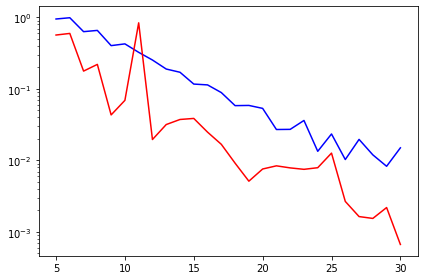

In [12]:
errors_NN  = np.array(errors)
errors_gNN = np.load('errors_gNN.npy')
plt.plot(train_nums, errors_NN, 'b-')
plt.plot(train_nums, errors_gNN, 'r-')
plt.yscale('log')
plt.tight_layout()
plt.savefig('Comparison between NN and gNN L2.pdf')
plt.show()

In [13]:
np.save('errors_NN.npy', errors_NN)

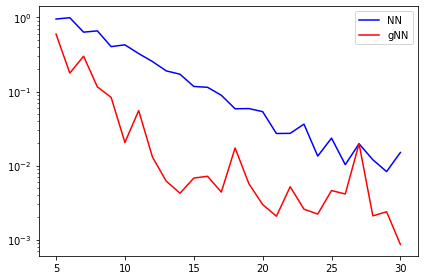

In [9]:
errors_gNN = np.load('errors.npy')
errors_NN = np.load('errors_NN.npy')

plt.plot(train_nums, errors_NN, 'b-', label='NN')
plt.plot(train_nums, errors_gNN, 'r-', label='gNN')
plt.yscale('log')
plt.tight_layout()
plt.legend()
plt.savefig('Comparison between NN and gNN L2.pdf')
plt.show()